# Hradness properties of a polycrystal
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the hardness map of a polycrystal.

The network is trained to predict the load-depth curves of nanoindented grains in steel. 

After training, the network's prediction ability is illustrated by comparing its output to the true hardness of the material.

# Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [1]:
# install_graph_nets_library = "No"  #@param ["Yes", "No"]

# if install_graph_nets_library.lower() == "yes":
#   print("Installing Graph Nets library and dependencies:")
#   print("Output message from command:\n")
#   !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
# else:
#   print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


# load libraries

In [10]:
import configparser
confParser = configparser.ConfigParser()
confParser.read('config.ini')
confParser.sections()


['Parameters', 'gnn library path', 'python libarary path', 'test data files']

In [18]:
import sys
sys.path.append(confParser['gnn library path']['gnnLibDir'])
sys.path.append(confParser['python libarary path']['pyLibDir'])
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import utility as utl
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
import os
import traceback
import imp
imp.reload(utl)
from scipy.spatial import KDTree
from scipy.interpolate import Rbf
import time

import functools
from typing import Any, Dict, Text,Tuple,Optional


import enum
import pickle
#from absl import logging
import numpy as np


import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

import sonnet as snt

from graph_nets import graphs
from graph_nets import modules as gn_modules
from graph_nets import utils_tf
from gnn_graphnet_model import *
from graph_nets import utils_np

from sklearn.preprocessing import StandardScaler
from scipy import stats


# utility funcs

In [4]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x].flatten(),self.neigh_mat))]
        assert np.all(list(map(lambda x:np.any(x>0.0),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[x>0.0],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: x.mean(), h_list))
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        
        
def load_test_data(test_data_file_path,test_data_file_path2nd):
    # read the csv file and return the text line list.
    test_data_row_list = pd.read_csv(test_data_file_path,sep=',')
    test_data_row_list2nd = pd.read_csv(test_data_file_path2nd,sep=',')
    print('open and load data from test_data.csv complete.')
    return test_data_row_list, test_data_row_list2nd

def train_test_split(x,y):
    xlo, xhi = x.min(), x.max()
    ylo, yhi = y.min(), y.max()
    x_copy = np.array(x.copy() - xlo)
    y_copy = np.array(y.copy() - ylo)
    
    return x_copy < 0.7 * (xhi-xlo)

    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               predictors,
                train_mask,
                test_mask,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    #--- do interpolation for missing attributes
#     interp = AddMissing(np.c_[test_data[['x','y']]],
#                          np.c_[test_data['h(Gpa)']],
#                          np.c_[test_data['h(Gpa)']==0.0],
#                                )

#     interp.kdTree(64) #--- nearest neighbors
#     interp.interpolate()

#     #--- update data frame
#     cols = list(test_data.keys())
#     cols.remove('h(Gpa)')
#     test_data = pd.DataFrame(np.c_[test_data[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])

    
    #--- assignment
    positions = np.c_[test_data[['x','y','perimeter','boundarySize','numNeighbors']]].tolist() 
    edges = list(map(lambda x:[x],np.array(test_data2nd['misOrientationAngle(deg)'])))
    receivers = list(test_data2nd['grain_j_index'].astype(int))
    senders = list(test_data2nd['grain_i_index'].astype(int)) 
    
    #--- target vector
#     xp=np.arange(0,1,0.01)
#     y=test_data['boundarySize'].apply(lambda x:x*xp**2+np.random.normal(size=len(xp)))
#     y = np.c_[y.to_list()]

    
    target = list(map(lambda x:list(x),predictors))
    #list(map(lambda x:[x],np.array(test_data['h(Gpa)']))) #list(map(lambda x:list(x),y)) #
#    target =  list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
#    train_mask = np.all(~np.isnan(predictors),axis=1)
    #train_test_split(test_data['x'],test_data['y']) #--- change!!!!
    
    val_mask = test_mask # = ~train_mask
    weight = list(np.ones(test_data.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op




# Creating graphs

## target data

In [5]:
class Finder():
    '''
    return a list of files in a directory
    '''
    def __init__(self,path_ld):
        self.files = os.listdir(path_ld)

    def Get(self,file_index):
        return self.files[file_index]
    
class TestData:
    '''
    return the feature matrix
    '''
    ld_curve = {}
    load = {}
    
    def __init__(self,path_ld,path_gb,verbose=False):
        self.path_ld = path_ld #--- ld data
        self.path_gb = path_gb #--- grain properties
        self.verbose = verbose

    def is_included(self,xlo,xhi):
        '''
        return bool: timeseries includes the range (xlo,xhi) 
        '''
        return self.data[:,0].min() <= xlo and self.data[:,0].max() >=  xhi   
            
    def Parse(self):
        if self.verbose:
            print('parsing %s'%(self.path_ld))
        self.data    = np.loadtxt( self.path_ld ) #--- load curve
        self.grains  = pd.read_csv(self.path_gb ,sep=',')
        
    def Interp(self,bins):
        '''
        interpolate on the structured grid bins
        '''
#        self.xsum = np.interp(bins, self.data[:,0], self.data[:,1], left=None, right=None, period=None)
#        self.edges = bins
        
        self.xsum = self.Rbf(self.data[:,1],len(bins))
        self.edges = self.Rbf(self.data[:,0],len(bins))
        
    def Rbf(self,data,nbins):
        x = np.linspace(0, 1, data.shape[0])
        d = data 
        rbfi = Rbf(x, d)
        xi = np.linspace(0, 1, nbins)
        return rbfi(xi)
            
    def GetGrainIndex(self):
        '''
        return grain index and id 
        '''
        GetGrainID = lambda x:x[x.find('ID_')+3:x.find('_LoadID')]
        GrainID = GetGrainID(self.path_ld)
        filtr = self.grains['#grainID']==float(GrainID)
        assert np.any(filtr), 'grainID %s not exist!'%GrainID
        return self.grains[filtr].index[0]

    def Scale(self):
        '''
        return scaled data 
        '''
        self.data[:,0] /= np.max(self.data[:,1]) #--- scale by fmax
        self.data[:,1] /= np.max(self.data[:,1])

    @staticmethod
    def Append(GrainIndex,disp,load):
        '''
        append stress timeseries
        '''
        TestData.ld_curve.setdefault(GrainIndex,[]).append(disp.copy()) #--- repetative
        TestData.load.setdefault(GrainIndex,[]).append(load.copy()) #--- repetative
        
    
    @staticmethod
    def BuildFeature(sdict,ngrains_total,n_ld):
    #--- build feature matrix
        keys=list(sdict.keys()) #--- indented grains
        mat = np.c_[list(map(lambda x:np.mean(np.c_[sdict[x]],axis=0),keys))] #--- matrix
        df = pd.DataFrame(np.c_[keys,mat]) #--- data frame
        df.sort_values(0,inplace=True)

        #--- non-indented grains
    #    =
        ngrains_indented = df.shape[0]
    #    n_ld = np.arange(xlo,xhi,dx).shape[0]
        ngrains = ngrains_total - ngrains_indented
        mat_nan = np.ones(ngrains*n_ld).reshape((ngrains,n_ld))*np.nan

        #--- combine
        mat_new = np.concatenate([df.drop(columns=[0]),mat_nan],axis=0)

    #--- row number
        ids=list(range(ngrains_total))
        list(map(lambda x:ids.remove(x),keys))
        keys = keys + ids

        df = pd.DataFrame(np.c_[keys,mat_new])
        return np.c_[df.drop(columns=[0])]

mkdir: png: File exists


'loadDepth_GrainID_211_LoadID4_IndentLabel_1.txt'

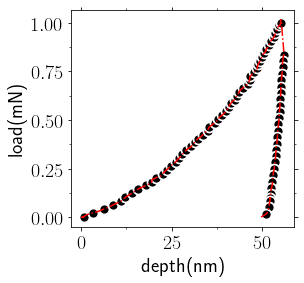

<AxesSubplot:xlabel='depth(nm)', ylabel='load(mN)'>

In [8]:
!mkdir png
symbols=utl.Symbols()

finder=Finder(confParser['test data files']['load_depth_path'])
display(finder.Get(0))

#--- parse load curve
test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],finder.Get(0)),
                     path_gb=confParser['test data files']['test_data_file_path'],
                    )

test_data.Parse()
test_data.Scale()
ax=utl.PltErr(test_data.data[:,0],test_data.data[:,1],
#                xlim=(0,20),ylim=(0,0.2),
               attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
              Plot=False,
               )
test_data.Interp(bins=np.arange(test_data.data[:,0].min(),test_data.data.max(),0.1))
utl.PltErr(test_data.edges,test_data.xsum,
#                xlim=(0,20),ylim=(0,0.2),
               attrs={'fmt':'-.r'},
                ax=ax,
               xstr='depth(nm)',
               ystr='load(mN)',
#               attrs=symbols.GetAttrs(fmt='-.r'),
               title='png/loadDepth.png'
            
                )

### multiple grains

open and load data from test_data.csv complete.


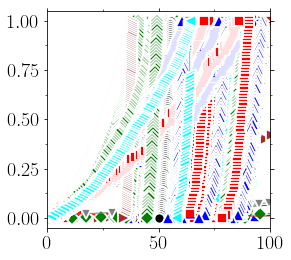

In [9]:
# test_data_file_path = confParser['test data files']['test_data_file_path']
# test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
# test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
#                                          test_data_file_path2nd
#                                         )
# ngrains = test_data_grains.shape[0]

# ax  = utl.PltErr(None,None,Plot=False)

# #--- prescribed range for displacements 
# (xlo,xhi,dx)=(0.0,1.0,0.01)

# #--- loop over indented grains
# TestData.ld_curve = {}
# TestData.load = {}
# for fp,count in zip(finder.files,range(len(finder.files))): 
#     test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],fp),
#                      path_gb=confParser['test data files']['test_data_file_path'],
#                      verbose=False,
#                     )
#     test_data.Parse()
#     test_data.Scale() #--- scale features
# #    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
# #        continue
#     test_data.Interp(bins=np.arange(xlo,xhi,dx)) #--- interpolate
#     try:
#         GrainIndex = test_data.GetGrainIndex()
#     except:
#         continue
#     #--- plot
# #     utl.PltErr(test_data.data[:,0],test_data.data[:,1],
# #                 attrs=symbols.GetAttrs(count=count%7),
# #                ax=ax,Plot=False,
# #                xlim=(0,100),#xhi),# ylim=(0,6),
# #               )
#     TestData.Append(GrainIndex,test_data.edges,test_data.xsum) #--- assemble feature matrix: append displacements
    
# #--- predictors are the displacements
# predictors = TestData.BuildFeature(TestData.ld_curve, 
#                                    ngrains,
#                                    np.arange(xlo,xhi,dx).shape[0]
#                                   )

# #---- forces
# forces = TestData.BuildFeature(TestData.load, 
#                                    ngrains,
#                                    np.arange(xlo,xhi,dx).shape[0]
#                                   )


### missing data

In [13]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index,verbose=False):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()
        self.verbose = verbose

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        if self.verbose:
            print('neigh_mat.shape:',self.neigh_mat.shape)
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x],self.neigh_mat))]
        if self.verbose:
            print('h_mat.shape:',h_mat.shape)
        assert np.all(list(map(lambda x:np.any(~np.isnan(x)),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[np.all(~np.isnan(x),axis=1)],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: np.mean(x,axis=0), h_list))
        if self.verbose:
            print('h_mean.shape:',h_mean[0].shape)
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        

# interp0 = AddMissing(np.c_[test_data_grains[['x','y']]],
#                      predictors,#np.c_[df.drop(columns=[0])],
#                      np.all(np.isnan(predictors),axis=1),
#                      verbose=True,
#                            )

# interp0.kdTree(64) #--- nearest neighbors
# interp0.interpolate()
# predictors = interp0.val.shape

## build graph

### train-test split

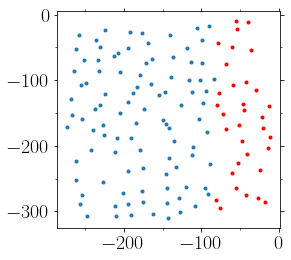

<AxesSubplot:>

In [14]:
# mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains
# mask_xy = train_test_split(test_data_grains['x'],test_data_grains['y']) #--- subset of grains

# #--- train-test split
# train_mask = np.all([mask_xy,mask],axis=0)
# test_mask = np.all([~mask_xy,mask],axis=0)

# #--- plot
# # ax=utl.PltErr(test_data_grains[train_mask]['x'],test_data_grains[train_mask]['y'],
# #               attrs={'fmt':'.'},
# #              Plot=False
# #              )

# # utl.PltErr(test_data_grains[test_mask]['x'],test_data_grains[test_mask]['y'],
# #               attrs={'fmt':'.','color':'red'},
# #            ax=ax
# #              )

In [15]:
def BadGrains(mask,slist):
    for i in slist:
        mask[i]=False
# BadGrains(train_mask,[0,21,43,50,86,109,112])
# BadGrains(test_mask,[0,21,43,50,86,109,112])

In [16]:
# #--- set parameters
# SEED =4441666
# np.random.seed(SEED)
# tf.set_random_seed(SEED)
# #
# pure_lab='' 
# data_split = None
# data_split_lab=''
# #


# #--- path for csv data files
# # test_data_file_path=confParser['test data files']['test_data_file_path']
# # test_data_file_path2nd=confParser['test data files']['test_data_file_path2nd']


# #--- graph structure  
# static_graph_tr, train_mask_np, val_mask_np, test_mask_np,\
# target_nodes_np, weight_np = base_graph(test_data_file_path, 
#                                         test_data_file_path2nd,
#                                         predictors,
#                                         train_mask,
#                                         test_mask,
#                                         logtrans=data_split)
# print(static_graph_tr.keys())
# for k in static_graph_tr.keys():
#     try:
#         print(k, static_graph_tr[k].shape)
#     except AttributeError:
#         print(k)

# input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
# graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
# #print(input_graph)




open and load data from test_data.csv complete.
dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])
globals
nodes
edges
receivers
senders
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [81]:
# import json
# with open('graph.json','w') as fp:
#     json.dump(static_graph_tr,fp)

In [82]:
#json.load(open('graph.json')).keys()

## plot h map

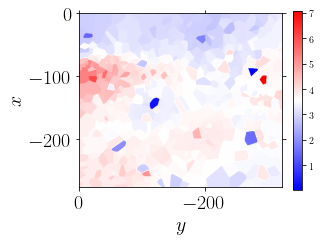

In [11]:
class interpolate:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_points):

        self.points    = cords
        self.query_points = query_points
        self.val = val.copy()

    def kdTree(self):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.query_points], k=1)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
        
    def interpolate(self):        
        return self.val[self.neigh_mat.flatten()]

    #--- do interpolation for missing attributes
# interp = AddMissing(np.c_[test_data_grains[['x','y']]],
#                      np.c_[test_data_grains['h(Gpa)']],
#                      np.c_[test_data_grains['h(Gpa)']==0.0],
#                            )

# interp.kdTree(64) #--- nearest neighbors
# interp.interpolate()

# #--- update data frame
# cols = list(test_data_grains.keys())
# cols.remove('h(Gpa)')
# test_data = pd.DataFrame(np.c_[test_data_grains[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])


# #--- discrete set of points 
# points=np.c_[test_data[['x','y']]]# #[static_graph_tr['nodes']][:,0:2]
    
# #--- plot hardness map
# [xlo,xhi]=[points[:,0].min(),points[:,0].max()]
# [ylo,yhi]=[points[:,1].min(),points[:,1].max()]
# dx=dy=0.5
# xlin = np.arange(xlo,xhi,dx)
# ylin = np.arange(ylo,yhi,dy)
# xv,yv=np.meshgrid(xlin,ylin)
# query_points = list(zip(xv.flatten(),yv.flatten()))

# #--- interpolate
# interp = interpolate(points,
#                      np.c_[test_data['h(Gpa)']],#' np.array(target_nodes_np),
#                      np.c_[query_points],
#                            )
# interp.kdTree()
# vi = interp.interpolate()
# vi = vi.reshape((xv.shape))

# #--- imshow
# n=vi.T.shape[1]
# val=np.array([vi.T[:,(n-1)-j] for j in range(n)])
# val.shape
# utl.PltBitmap( val.T,
#                xlabel = '$y$', ylabel = '$x$',
#                xlim = (yhi,ylo), ylim = (xlo,xhi),
#                frac = 1.0, #--- plot a patch
#                zscore = False,
#                title = 'cxy.png',
#                colorbar=True,
#               origin='lower'
# #               **kwargs
#               )

## Visualize 
### euclidean space

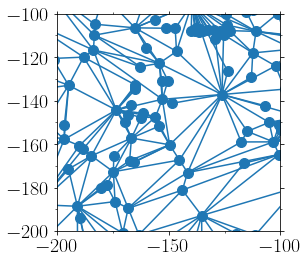

<AxesSubplot:>

In [277]:
# ax=utl.PltErr(np.c_[static_graph_tr['nodes']][:,0],
#          np.c_[static_graph_tr['nodes']][:,1],
#          fmt='.',
#         markersize=10,
#                Plot=False,
#         )
# for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
#     x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
#     y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
#     utl.PltErr(x,y,
#                attrs={'fmt':'-','color':'C0'},
#                ax=ax,
#                   Plot=False,
#               )
    

# utl.PltErr(None,None,ax=ax,
#             xlim=(-200,-100),
#             ylim=(-200,-100),
#             title='png/graph.png'
#           )

### nodes and edges

In [12]:
def get_cmap(n):
    colors = [(1,1,1)] + [(np.random.random(),np.random.random(),np.random.random()) for i in range(n-1)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=n)
    return new_map

#new_map = get_cmap(test_data_grains.shape[0])

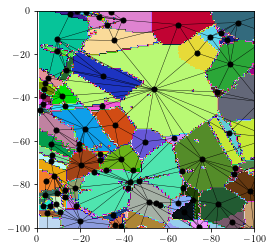

In [16]:
# #--- plott grains
# id_matrix = np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path'],
#           )
# n=id_matrix.T.shape[1]
# val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
# points=np.c_[test_data_grains[['x','y']]]
# [xlo,xhi]=[points[:,0].min(),points[:,0].max()]
# [ylo,yhi]=[points[:,1].min(),points[:,1].max()]
# plt.imshow(val.T,
# #            id_matrix,
#             origin='lower',
#             extent = (yhi,ylo,xlo,xhi),
# #               extent = (0,-100,-100,0),
#             cmap=new_map
#           )


# #--- plot centers
# pixel_cutoff=1
# filtr = test_data_grains['grainSize']>pixel_cutoff
# points=np.c_[test_data_grains[filtr][['x','y']]]
# xt=points[:,0] 
# yt=points[:,1]
# plt.plot(yt,
#          xt,
#          '.',color='black',
#          markersize=10,
#         )

# #--- plot edges
# singlePixel = test_data_grains[test_data_grains['grainSize']<=pixel_cutoff].index
# for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
#     if i in singlePixel or j in singlePixel:
#         continue
#     x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
#     y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
#     plt.plot(y,x,
#                '-',color='black',
#              markersize=12,
#              lw=.4,
#               )

# #--- range
# plt.xlim(0,-100)
# plt.ylim(-100,0)
# plt.savefig('png/gnn.png',bbox_inches='tight',pad_inches=0.0,dpi=300)

### plot indented grains

In [13]:
mask = np.all(np.isnan(predictors),axis=1)
grainID_notindented = np.c_[test_data_grains[mask]['#grainID']].astype(int)

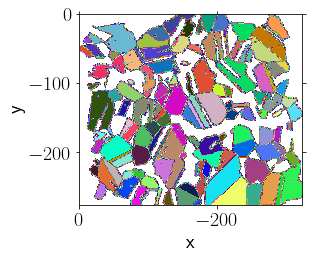

<Figure size 432x288 with 0 Axes>

In [103]:
class PlotGrains:
    def __init__(self,id_matrix,val=None):
    
        self.id_matrix = id_matrix #--- grain-id matrix 
        self.val = val
        
    def Bounds(self,points):
        [self.xlo,self.xhi]=[points[:,0].min(),points[:,0].max()]
        [self.ylo,self.yhi]=[points[:,1].min(),points[:,1].max()]

    def Mask(self,grainID_notindented):
        for grain_id in grainID_notindented.flatten(): #--- not show indented grains
                self.id_matrix[self.id_matrix == grain_id]=0
        
    def MaskField(self,grainID_notindented):
        for grain_id in grainID_notindented.flatten(): #--- not show indented grains
                self.val[self.id_matrix == grain_id] = np.nan

    def Transform(self):
        n=self.id_matrix.T.shape[1]
        self.id_matrix =np.array([self.id_matrix.T[:,(n-1)-j] for j in range(n)]) #--- transform
        
    def TransformField(self):
        n=self.val.T.shape[1]
        self.val = np.array([self.val.T[:,(n-1)-j] for j in range(n)]) #--- transform

        
    def PlotOrientation(self):
        new_map = get_cmap(len(set(self.id_matrix.flatten())))
        utl.PltBitmap(self.id_matrix.T,
                   xlim = (self.yhi,self.ylo),
                    ylim = (self.xlo,self.xhi),
                      zscore=False,
                    cmap=new_map,
                  )
        plt.savefig('png/indented.png',bbox_inches='tight',pad_inches=0.0,dpi=300)

    def PlotField(self):
        utl.PltBitmap(self.val.T,
        #            id_matrix,
#                    origin='lower',
                      xlabel='',ylabel='',
                    xlim = (self.yhi,self.ylo),
                    ylim = (self.xlo,self.xhi),
                      zscore=False,
                      colorbar=True,
                    cmap=['jet','gray','rainbow','seismic','bwr'][-1],#new_map,
                  )

# plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) #--- bitmap of grain ids
#                   )
# plott.Bounds(np.c_[test_data_grains[['x','y']]])
# plott.Transform()
# plott.Mask(grainID_notindented)
# plott.PlotOrientation()



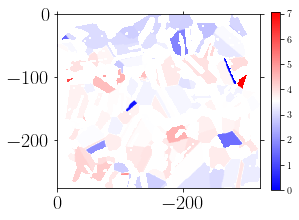

In [104]:

# h_mat=np.zeros(id_matrix.shape[0]*id_matrix.shape[1]).reshape((id_matrix.shape[0],id_matrix.shape[1]))
# h_mat.shape
# for grainID in test_data_grains['#grainID']:
#     h=test_data_grains[test_data_grains['#grainID']==grainID].iloc[0]['h(Gpa)']
#     h_mat[id_matrix==grainID]=h

    
# plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']),
#                     h_mat #--- bitmap of grain ids
#                   )
# plott.Bounds(np.c_[test_data_grains[['x','y']]])
# plott.Transform()
# plott.TransformField()
# plott.MaskField(grainID_notindented)
# plott.Mask(grainID_notindented)
# plott.PlotField()


# Train

In [19]:
# num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']) #3
# #--- Data / training parameters.
# num_training_iterations = eval(confParser['Parameters']['num_training_iterations']) #20000 #8000 #000#0 #20000
# learning_rate = eval(confParser['Parameters']['learning_rate']) #1e-2/4 #7.5e-6

# train_mask = tf.constant(train_mask_np, dtype=tf.bool)
# test_mask  = tf.constant(test_mask_np , dtype=tf.bool)
# val_mask   = tf.constant(val_mask_np  , dtype=tf.bool)

# target_nodes = tf.constant(target_nodes_np)
# weight = tf.constant(weight_np)
# weight = None ##NOTE comment out if weights wanted 


# # Create the model.
# node_output_size = len(target_nodes_np[0])
# model = EncodeProcessDecode(node_output_size=node_output_size)
# #print(model.summary())

# #--- training base graph
# output_ops, latent_ops = model(input_graph, num_processing_steps_tr) #[-1]
# # Training loss.
# loss_op_tr = []
# loss_op_va = []
# loss_op_ts = []
# corr_op_tr = []
# corr_op_va = []
# corr_op_ts = []

# for op in output_ops:
#     loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
#     loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
#     loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
#     corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
#     corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
#     corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

# # Training loss across processing steps.
# loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


# # Optimizer.
# optimizer = tf.train.AdamOptimizer(learning_rate)
# step_op = optimizer.minimize(loss_op_tr_sum)


# training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
# correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
# counter = 0


# # This cell resets the Tensorflow session, but keeps the same computational
# # graph.
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# print(snt.format_variables(model.variables))

# best_corr = np.zeros((num_processing_steps_tr,3))
# best_val_loss = np.inf
# best_corr_loss = 0.0
# best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
# best_corr_loss_all = np.zeros(num_processing_steps_tr)
# last_improved = 0
# early_stopping_crit = num_training_iterations #1000


# measure_val_by_loss= True
# print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# # #--- training loop
# t0 = time.time()
# for iteration in range(num_training_iterations):
#     last_iteration = iteration
#     train_values = sess.run({
#         "step": step_op,
#         "loss": loss_op_tr,
#         "outputs": output_ops,
#         "latents": latent_ops,
#         "corr": corr_op_tr

#     })
    

#     test_values = sess.run({
#         "loss_val":  loss_op_va,
#         "loss_test": loss_op_ts,
#             "corr_val": corr_op_va,
#             "corr_test": corr_op_ts
#     })
#     training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
#     training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
#     training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

#     correlat_history[counter, 0:num_processing_steps_tr] = np.median(train_values['corr'])
#     correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = np.median(test_values['corr_val'])
#     correlat_history[counter, 2*num_processing_steps_tr:] = np.median(test_values['corr_test'])



#     if (iteration+1) %100==0:
#         print("# {:05d}, training {:.4f}, validation {:.4f}, test {:.4f}".format(iteration+1,training_history[counter,num_processing_steps_tr-1], training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1]  ))

#         for i in range(num_processing_steps_tr):
#             if measure_val_by_loss:
#                 cond =  (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i])
#                 cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
#             else:
#                 cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
#                 cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
#             if cond:
#                 step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
# #                 pdb.set_trace()
#                 best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
#                 best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
#                 best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
#                 #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))
#                 best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i]
#                 best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]
#                 if cond_best:
#                     best_output = np.copy(step_output)
#                     best_latent = sess.run(latent_ops[i])
#                     #print(best_latent.shape)
#                     best_val_loss = training_history[counter,num_processing_steps_tr+i]
#                     best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
#                     last_improved = counter
#     counter+=1 
#     if counter > last_improved + early_stopping_crit:
#         print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
#         break


# f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

# training_history = training_history[:counter]
# correlat_history = correlat_history[:counter]
# for i in range(num_processing_steps_tr):
#     print("    {} steps:  best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
#     latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
# #     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



# # np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
# # np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
# # np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
# # np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)


Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_1/graph_independent/node_model/node_output/b       100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_1/graph_independent/node_model/node_output/w       8x100  float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/linear_0/w      1x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/li

# 00900, training 15402.4395, validation 929.9922, test 929.9922
# 01000, training 15249.5166, validation 890.6782, test 890.6782
    1 steps:  best val res, r: training 0.2135, validation 0.5257, test 0.5257
    2 steps:  best val res, r: training 0.2135, validation 0.5257, test 0.5257
    3 steps:  best val res, r: training 0.2135, validation 0.5257, test 0.5257


In [20]:
print('elapsed times:%ss'%(time.time()-t0))

elapsed times:48.34972906112671s


## mse

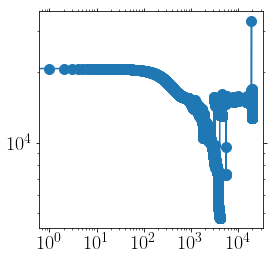

<AxesSubplot:>

In [14]:
# utl.PltErr(range(training_history.shape[0]),
#            training_history[:,num_processing_steps_tr-1],
#            xscale='log',
#            yscale='log',
#           )

In [37]:
# i=1
# tep_output =  sess.run(output_ops[i].nodes)
# best_output = np.copy(step_output)

In [38]:
# with sess.as_default():
#     print(output_ops[0].receivers.eval().shape)

## predictions

In [39]:
# !mkdir png
# #ax=utl.PltErr(target_nodes_np,target_nodes_np,attrs={'fmt':'-r'},Plot=False)
# filtr = [train_mask_np,test_mask_np][1]
# xmin=np.min([target_nodes_np,best_output])
# xmax=np.max([target_nodes_np,best_output])
# utl.PltErr(np.array(target_nodes_np)[filtr], np.array(best_output)[filtr],
#            attrs={'fmt':'.'},
#             xlim=(xmin,xmax),
#            ylim=(xmin,xmax),
#            title = 'png/hardness.png',
#            xstr='actual',
#            ystr='predicted',
# #           ax=ax,
#           )

grain_indx= 0


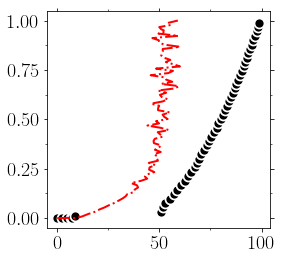

grain_indx= 1


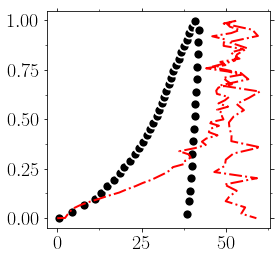

grain_indx= 5


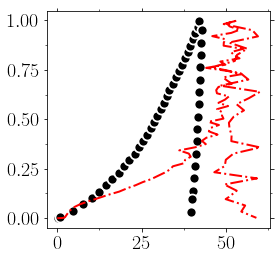

grain_indx= 14


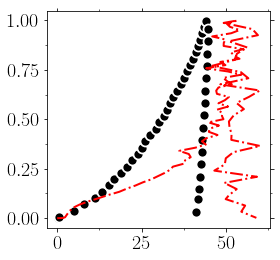

grain_indx= 17


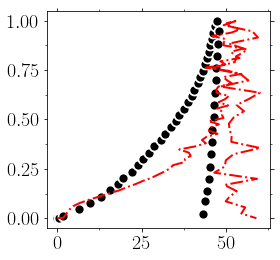

grain_indx= 25


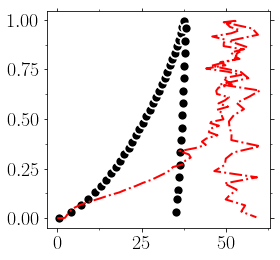

grain_indx= 28


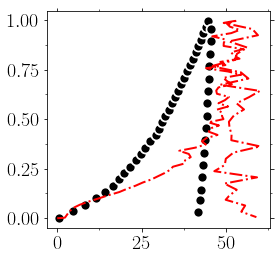

grain_indx= 44


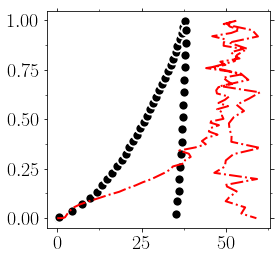

grain_indx= 46


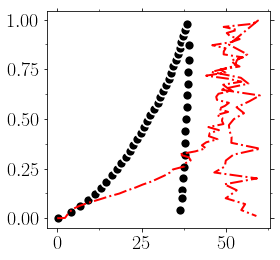

grain_indx= 49


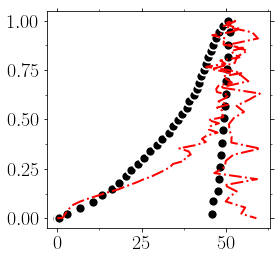

grain_indx= 52


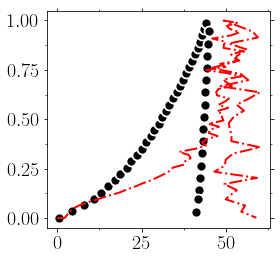

grain_indx= 53


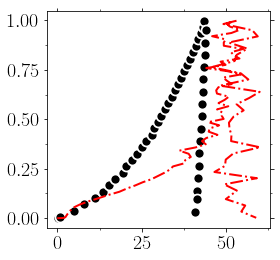

grain_indx= 55


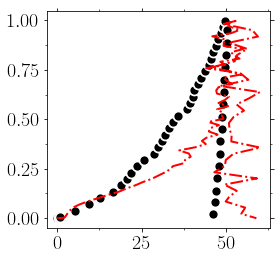

grain_indx= 62


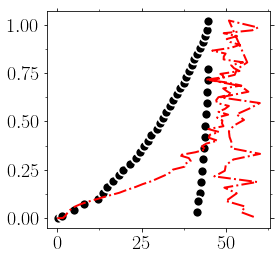

grain_indx= 63


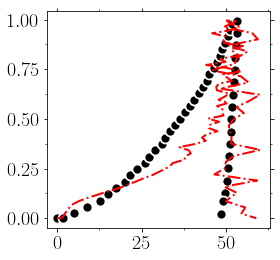

grain_indx= 65


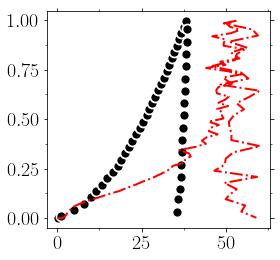

grain_indx= 66


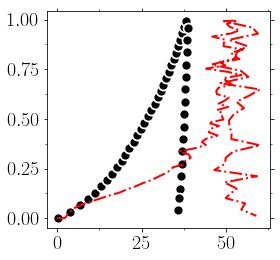

grain_indx= 73


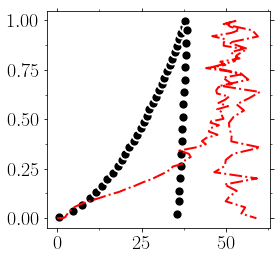

grain_indx= 74


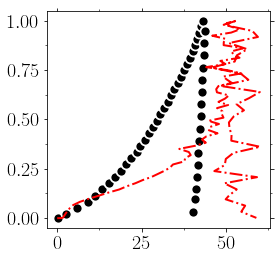

grain_indx= 75


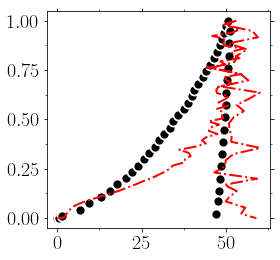

grain_indx= 81


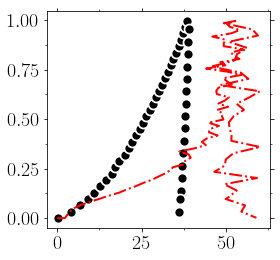

grain_indx= 83


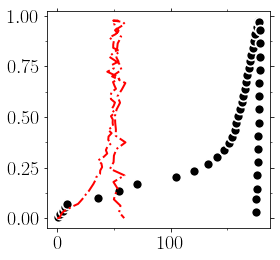

grain_indx= 88


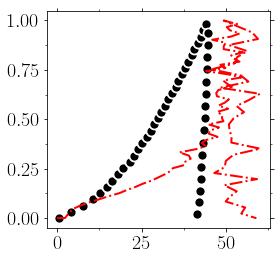

grain_indx= 89


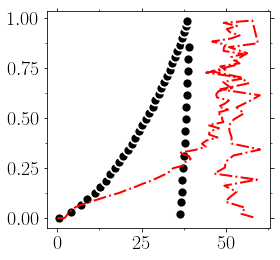

grain_indx= 94


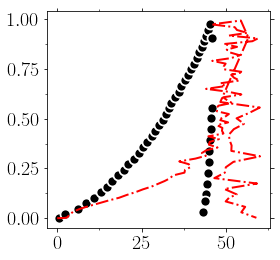

grain_indx= 97


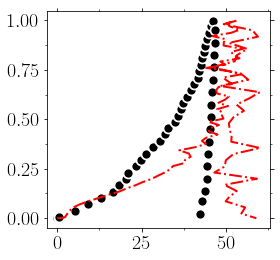

grain_indx= 100


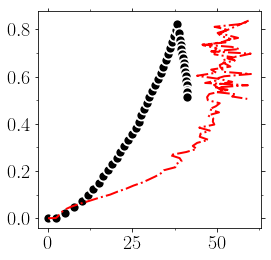

grain_indx= 113


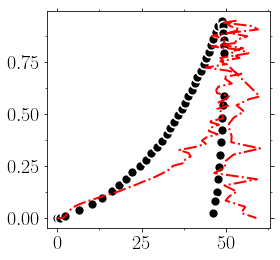

grain_indx= 114


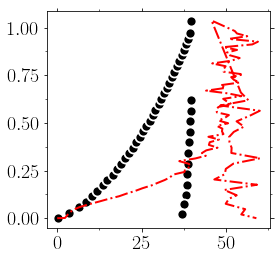

grain_indx= 118


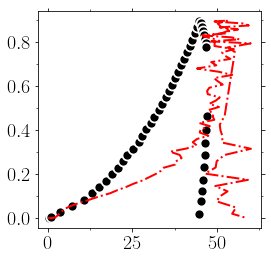

grain_indx= 119


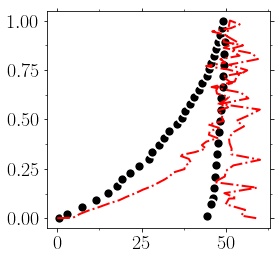

grain_indx= 122


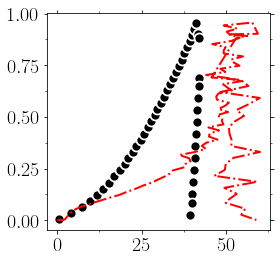

grain_indx= 124


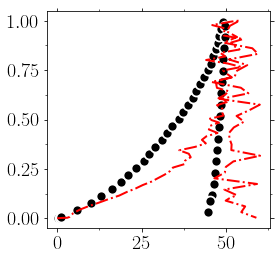

In [15]:
# grain_indx=5
# if train_mask_np[grain_indx]:
#     print('training set')
# else:
#     print('test set')

# for grain_indx in range(len(target_nodes_np)):
#     if not test_mask_np[grain_indx]:
#         continue
#     print('grain_indx=',grain_indx)
#     ax=utl.PltErr(None,None,Plot=False)
#     utl.PltErr(
# #                range(len(target_nodes_np[grain_indx])),
#                target_nodes_np[grain_indx], 
#                forces[grain_indx],
#                attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
#                 Plot=False,
#                ax=ax
#                  )

#     utl.PltErr(
#                best_output[grain_indx],
#                        forces[grain_indx],

#                attrs={'fmt':'-.','lw':2,'color':'red'},
#     #            xlim=(xmin,xmax),
#     #           ylim=(xmin,xmax),
#     #           title = 'png/hardness.png',
# #                xstr='disp',
# #                ystr='load',
#                ax=ax,
#                                Plot=False,
# #                 xlim=(0,125),
# #                 ylim=(0,1.3),

#               )
    
#     utl.PltErr(None,None,
#                ax=ax,
#                title='png/prediction%s.png'%grain_indx,
#               dpi=55,
#               )


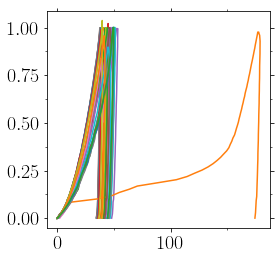

In [86]:
# ax=utl.PltErr(None,None,Plot=False)
# for grain_indx in range(len(target_nodes_np)):
#     if not test_mask_np[grain_indx]:
#         continue

#     utl.PltErr(
#                target_nodes_np[grain_indx], 
#                 forces[grain_indx],
# #               best_output[grain_indx],
#                attrs={'fmt':'-'},
#     #            xlim=(xmin,xmax),
#     #           ylim=(xmin,xmax),
#     #           title = 'png/hardness.png',
# #                xstr='disp',
# #                ystr='load',
#                ax=ax,
#                                Plot=False,

#               )

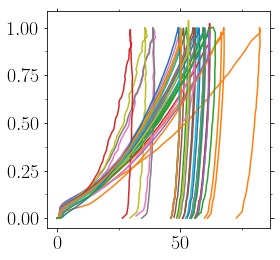

In [87]:
# ax=utl.PltErr(None,None,Plot=False)
# for grain_indx in range(len(target_nodes_np)):
#     if not test_mask_np[grain_indx]:
#         continue

#     utl.PltErr(
#                best_output[grain_indx],
#                         forces[grain_indx],

#                attrs={'fmt':'-'},
#     #            xlim=(xmin,xmax),
#     #           ylim=(xmin,xmax),
#     #           title = 'png/hardness.png',
# #                xstr='disp',
# #                ystr='load',
#                ax=ax,
#                                Plot=False,

#               )

<AxesSubplot:>

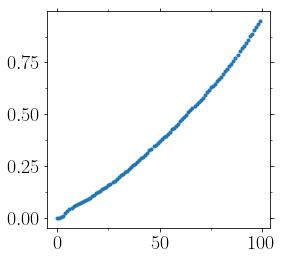

In [48]:
# grain_indx=1080
# utl.PltErr(range(len(target_nodes_np[grain_indx])),
#            target_nodes_np[grain_indx], 
#            attrs={'fmt':'.'},
#             Plot=False
#              )

### predict hardness

In [41]:
# def func(x,a,b):
#     return a * x + b

# def MeasureHardness(ld,Plot=False,verbose=False):
#     pmax = ld.Force.max()
#     tunload = ld.Time[ld.Force>=pmax].iloc[-1]
#     dt = 0.4 * tunload
#     filtr = np.all([ld.Time>tunload,ld.Time<tunload+dt],axis=0)
#     z = np.polyfit(ld.Depth[filtr],ld.Force[filtr],deg=1)
#     if Plot:
#         utl.PltErr(ld.Time[filtr],ld.Force[filtr],
#                   xstr=r'Time(s)',
#                    ystr=r'Load(mN)',
#                   )

#         utl.PltErr(ld.Time[filtr],ld.Depth[filtr],
#                    xstr=r'Time(s)',
#                    ystr=r'Depth(nm)',
#                   )

#         ax=utl.PltErr(ld.Depth,ld.Force,
#                      Plot=False,
#                      )
#         utl.PltErr(ld.Depth,func(ld.Depth,*z),
#                    fmt='-.r',
#                    label=r'$s=%3.2f$'%z[0],
#                    legend = True,
#                    ax=ax,
#                    xstr=r'Depth(nm)',
#                    ystr=r'Load(mN)',
#                    xlim=(hlo,hhi),
#                   )

#         ax=utl.PltErr(ld.Depth[filtr],ld.Force[filtr],
#                      Plot=False,
#                      )
#         utl.PltErr(ld.Depth[filtr],func(ld.Depth[filtr],*z),
#                    fmt='-.r',
#                    label=r'$s=%3.2f$'%z[0],
#                    legend = True,
#                    ax=ax,
#                    xstr=r'Depth(nm)',
#                    ystr=r'Load(mN)',
#                   )
        
#     pmax = ld.Force.max()#*1e-3 #--- mN
#     hmax = ld.Depth.max()#*1e-9 #--- nm
#     slope=z[0] #*1e-3/1e-9
#     hs = 0.72 * pmax / slope
#     hc = hmax - hs
#     area = 24.5 * hc * hc 

#     hardness = pmax / area
#     if verbose:
#         print('hardness=%3.2f Gpa'%(1e-9*hardness))

#     return hardness

### unscaled data

In [58]:
# test_data_file_path = confParser['test data files']['test_data_file_path']
# test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
# test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
#                                          test_data_file_path2nd
#                                         )
# ngrains = test_data_grains.shape[0]


# #--- prescribed range for displacements 

# #--- loop over indented grains
# TestData.ld_curve = {}
# TestData.load = {}
# for fp,count in zip(finder.files,range(len(finder.files))): 
#     test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],fp),
#                      path_gb=confParser['test data files']['test_data_file_path'],
#                      verbose=False,
#                     )
#     test_data.Parse()
# #    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
# #        continue
#     try:
#         GrainIndex = test_data.GetGrainIndex()
#     except:
#         continue
#     #--- 1.0e-9 and 1.0e-3: get si units
#     #--- assemble feature matrix: append displacements and forces
#     TestData.Append(GrainIndex,[test_data.data[:,0].max()],[test_data.data[:,1].max()]) 
    
# #--- predictors are the displacements
# predictors = TestData.BuildFeature(TestData.ld_curve, 
#                                    ngrains,
#                                    1
#                                   )

# #---- forces
# forces2 = TestData.BuildFeature(TestData.load, 
#                                    ngrains,
#                                    1
#                                   )


open and load data from test_data.csv complete.


In [63]:
# h_pred = []
# h_actual = []

# for grain_indx in range(len(target_nodes_np)):
# #    if not test_mask_np[grain_indx]:
# #        continue

#     try:
#         print(grain_indx)
#         #--- scale by max force
#         disp_pred   = best_output[grain_indx] * forces2[grain_indx]
#         disp_actual = target_nodes_np[grain_indx] * forces2[grain_indx]

#         force = forces[grain_indx] * forces2[grain_indx]


#         ld_pred=pd.DataFrame(np.c_[range(disp_pred.shape[0]),1.0e-9*disp_pred, 1.0e-3*force],
#                         columns=['Time','Depth','Force'])
#         ld_actual=pd.DataFrame(np.c_[range(disp_actual.shape[0]),1.0e-9*disp_actual, 1.0e-3*force],
#                         columns=['Time','Depth','Force'])

#         h_pred += [1.0e-9*MeasureHardness(ld_pred,Plot=False,verbose=True)]
#         h_actual += [1.0e-9*MeasureHardness(ld_actual,Plot=False,verbose=True)]
#     except:
#         continue

0
1
hardness=3.01 Gpa
hardness=3.69 Gpa
2
hardness=3.47 Gpa
hardness=4.42 Gpa
3
hardness=3.79 Gpa
hardness=3.81 Gpa
4
hardness=5.18 Gpa
hardness=6.34 Gpa
5
hardness=2.97 Gpa
hardness=3.51 Gpa
6
hardness=3.84 Gpa
hardness=3.90 Gpa
7
hardness=3.92 Gpa
hardness=3.75 Gpa
8
hardness=4.22 Gpa
hardness=4.27 Gpa
9
hardness=4.62 Gpa
hardness=5.73 Gpa
10
hardness=4.10 Gpa
hardness=4.24 Gpa
11
hardness=3.28 Gpa
hardness=3.73 Gpa
12
hardness=3.69 Gpa
hardness=4.27 Gpa
13
hardness=4.20 Gpa
hardness=4.32 Gpa
14
hardness=2.89 Gpa
hardness=3.22 Gpa
15
hardness=5.18 Gpa
hardness=3.97 Gpa
16
hardness=4.14 Gpa
hardness=4.00 Gpa
17
hardness=2.22 Gpa
hardness=4.01 Gpa
18
hardness=4.63 Gpa
hardness=3.71 Gpa
19
hardness=4.18 Gpa
hardness=3.96 Gpa
20
hardness=4.07 Gpa
hardness=3.72 Gpa
21
22
hardness=4.24 Gpa
hardness=4.12 Gpa
23
hardness=3.86 Gpa
hardness=3.78 Gpa
24
hardness=4.79 Gpa
hardness=5.00 Gpa
25
hardness=2.10 Gpa
hardness=3.09 Gpa
26
hardness=3.62 Gpa
hardness=3.75 Gpa
27
hardness=4.30 Gpa
hardness

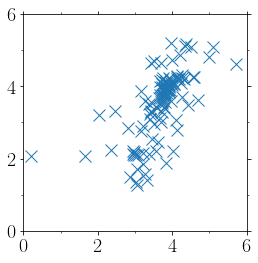

<AxesSubplot:>

In [64]:
# xmin,xmax=np.min(h_actual),np.max(h_actual)
# ymin,ymax=np.min(h_pred),np.max(h_pred)
# minn=0#.9*np.min([xmin,ymin])
# maxx=6#1.1*np.max([xmax,ymax])
# utl.PltErr(np.array(h_actual),
#           np.array(h_pred),
#            attrs={'fmt':'x','markersize':12},
#            xlim=(minn,maxx),
#            ylim=(minn,maxx),
#           )